# Objectives

Perform Model comparison of two different models employing Neural Estimation methods.

> **Disclaimer:**
> We did not have the time to perform the full comparison, just one model.

> **Who's to blame?**
> TDD.

> **(Are we sad?)**
> No, At least we learned TDD.

## First, Import all relevant modules. 

Can you spot our transient_smash classes? :D 

In [ ]:
from transient_smash.models.model import SinusoidalModelWithNoise
from transient_smash.sbi_interface.sbi_interface import NLESBI
import matplotlib.pyplot as plt
import numpy as np
from nautilus import Sampler, Prior
from sbi.inference import likelihood_estimator_based_potential
import torch
from sbi.analysis import pairplot

## Set stuff up

Here, we set the number of simulations and the number of observations, as well as the number of (noisy) parameters.

In [2]:
n_simulations = 1000 # We want 1000 simulations
n_observations = 1000 # We want 1000 obs in time
x = np.linspace(0,10,n_observations) 
noisy_params = [1,1,1,1,0,1] # set 6 params by specifying their mean values

## Simulate and Plot the "True" Observations
We go for a sinusoidal model, and plot them with the good old matplotlib.

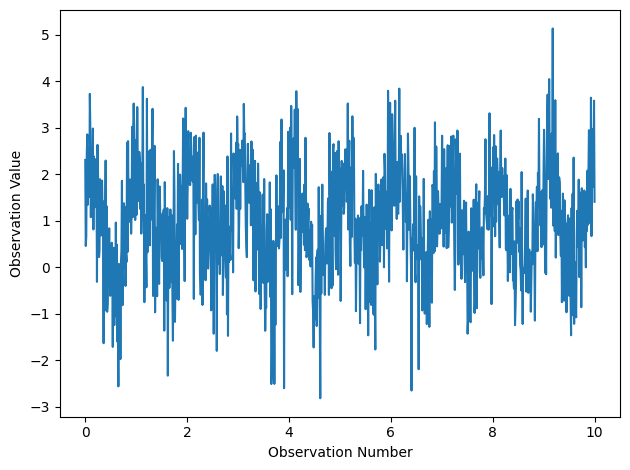

In [3]:
true_model = SinusoidalModelWithNoise() # instantiate model
observations = true_model.evaluate(x,noisy_params) # create observations

# Plot observations
plt.plot(x,observations)
plt.ylabel('Observation Value')
plt.xlabel('Observation Number')
plt.tight_layout()
plt.show()
plt.close()

## Create our first model (test_model_1)

At this stage, we also set the priors. We define six, as descriptive of a 1D light curve...

In [4]:
test_model_1 = SinusoidalModelWithNoise() # define test model
priors_dict = {"amplitude": ("uniform", 0.0, 2.0),
               "frequency": ("uniform", 0.0, 2.0),
               "phase": ("uniform", 0.0, 2.0),
               "offset": ("uniform", 0.0,2.0),
               "mean": ("uniform", -1.0,1.0),
               "std": ("uniform", 0.0,2.0)}

## Extract the Simulated observations (test_model_1)


In [5]:
_ = test_model_1.set_priors(priors_dict) # set priors
priors_1 = test_model_1.get_sbi_priors() # get the priors object
theta_1 = priors_1.sample((n_simulations,)) # sample the priors to get parameters
_ = test_model_1.set_input_data(x) # set input data to produce simulations
simulator_1 = test_model_1.get_sbi_simulator() # get simulator object
y_1 =  simulator_1(theta_1) # extract observations from simulator object

## Train the Network (Neural Likelihood Estimation)

In [6]:
nle_sbi= NLESBI() # instantiate SBI class
inference_object_1 = nle_sbi.create_inference_object(priors_1) # create inference object
likelihood_net_1, posterior_distribution_1 = nle_sbi.compute_distribution(inference_object_1, theta_1, y_1) # get likelihood network

 Neural network successfully converged after 350 epochs.

/opt/homebrew/anaconda3/envs/sbi_test/lib/python3.11/site-packages/sbi/inference/posteriors/mcmc_posterior.py:126: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


## Sample the Distribution

In [7]:
distribution_theta = nle_sbi.sample_distribution(posterior_distribution_1, theta_1, observations)

Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/11000 [00:00<?, ?it/s]

## Plot the Parameter Distributions

(<Figure size 1000x1000 with 36 Axes>,
 array([[<Axes: xlabel='amplitude'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='frequency'>, <Axes: >, <Axes: >,
         <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='phase'>, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='offset'>, <Axes: >,
         <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: xlabel='mean'>,
         <Axes: >],
        [<Axes: xlabel='amplitude'>, <Axes: xlabel='frequency'>,
         <Axes: xlabel='phase'>, <Axes: xlabel='offset'>,
         <Axes: xlabel='mean'>, <Axes: xlabel='std'>]], dtype=object))

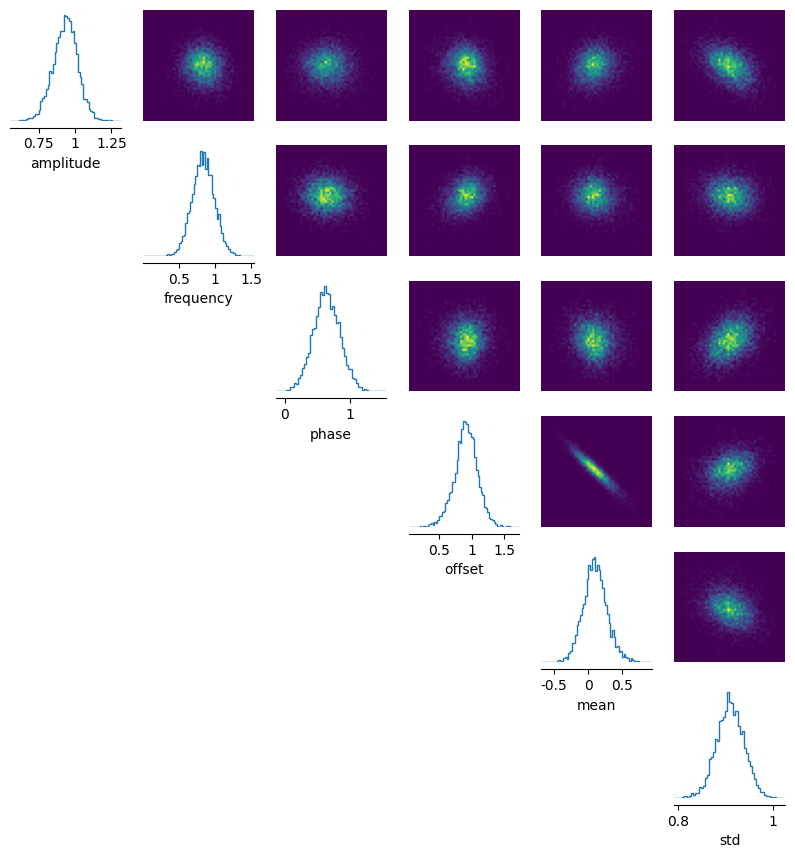

In [26]:
pairplot(distribution_theta, labels = list(priors_dict.keys()))

## From here on, no Transient Smash's Interface. Only Nautilus.

> **PLAN**: make wrapper functions for these as well

In [8]:
potential_fn, _ = likelihood_estimator_based_potential(likelihood_net_1, priors_1, y_1, enable_transform=False)

In [10]:
def log_likelihood_nautilus(param_dict):
    """
    Likelihood function for Nautilus using SBI-trained likelihood estimator.
    
    The key insight is that SBI's likelihood estimator is p(x|theta), so we need:
    - x: the observed data (y_obs)  
    - theta: the parameters we're evaluating
    """
    # Extract parameters
    numpy_theta = np.array([param_dict[key] for key in priors_dict.keys()])
    
    # Create parameter tensor
    theta = torch.tensor(numpy_theta, dtype=torch.float32)
    
    if len(theta.shape) == 1:
        theta = theta.unsqueeze(0)
        
    return potential_fn(theta).detach().numpy().flatten()[0]

In [27]:
prior_nautilus = Prior()

for key, value in priors_dict.items():
    prior_nautilus.add_parameter(key, dist=(value[1], value[2]))


sampler = Sampler(prior_nautilus, log_likelihood_nautilus, n_live=1000)
sampler.run(verbose=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 48     | 1        | 4        | 55400    | N/A    | 10070 | -1799261.


np.True_

# Ooops...
# But hey, our Unit Tests work!

In [30]:
# Get likelihood
log_z_likelihood = sampler.log_z
print(log_z_likelihood)

-1799261.6488242536
